## Time Series Patterns

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

### Load Data

Create a function called load_data that reads in the csv file and produces a pd.Series

In [2]:
def load_data():
    df = pd.read_csv('Data/time_series_covid19_confirmed_global.csv')
  
    #Drop columns that are not related
    df = df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
    
    #Sum all cases for each date since it's a global count.
    total_cases = df.sum(axis=0)
    
    #Calculate the daily new cases by subtracting the previous day's cumulative cases from the current day.
    daily_new_cases = total_cases.diff().dropna()
    # Convert the index to a DatetimeIndex
    daily_new_cases.index = pd.to_datetime(daily_new_cases.index)

    
    return daily_new_cases

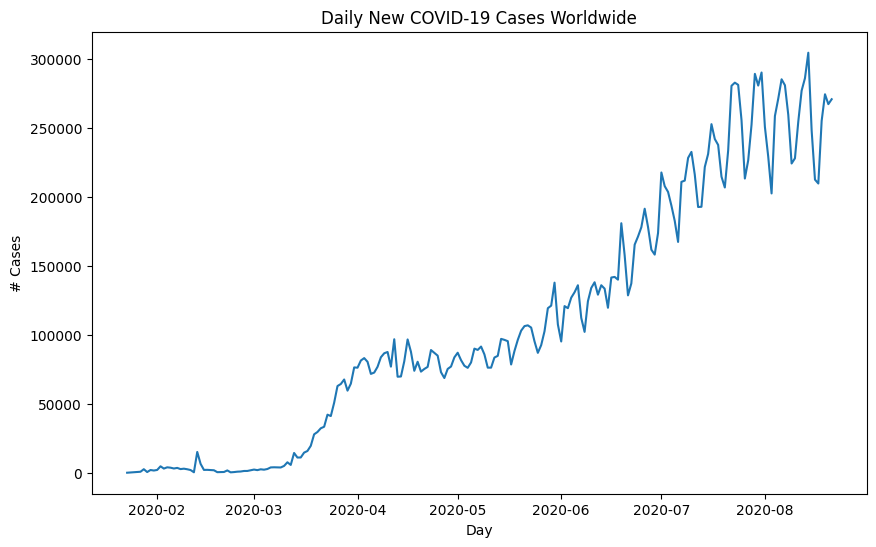

In [3]:
# Let's plot and see the time series

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(load_data())
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")

del fig, ax

### Perform a Seasonal Decomposition

With the time series ready, let's first perform a seasonal decomposition using tools from the statsmodels library to get a sense of what the possible patterns are hidden in the data

To perform a seasonal decomposition using statsmodels, you can use the seasonal_decompose function directly. This function decomposes a time series into its components: trend, seasonal, and residual.

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

def sea_decomp(ser, model="additive"):
    """
    Takes in a series and a "model" parameter indicating which seasonal decomp to perform
    """
    
    # Decomposing the time series based on the provided model (either "additive" or "multiplicative")
    result = seasonal_decompose(ser, model=model) 
    
    return result


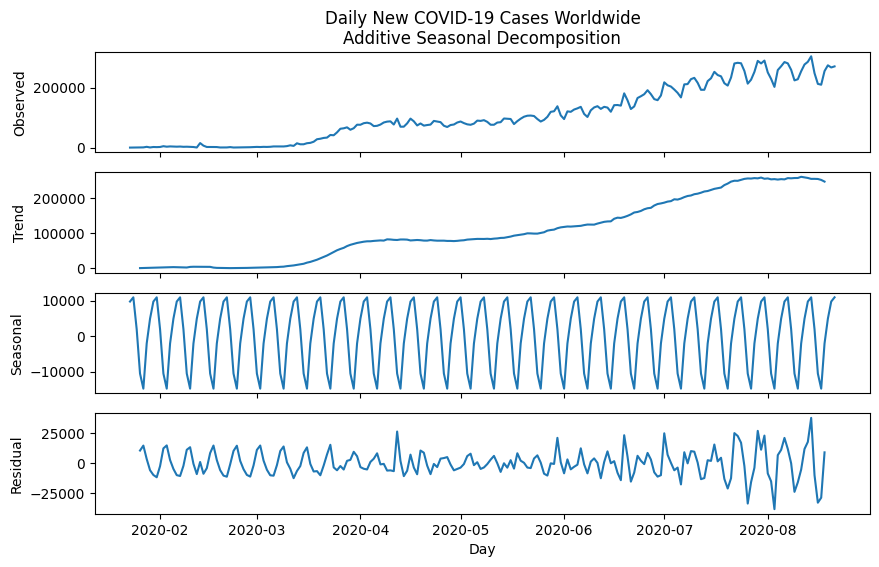

In [5]:
# Let's plot and see the seasonal decomposition

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
res = sea_decomp(load_data(), model="additive")

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(res.observed)
axes[0].set_ylabel("Observed")

axes[1].plot(res.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(res.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(res.resid)
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Day")
fig.suptitle("Daily New COVID-19 Cases Worldwide", x=0.513, y=0.95)

del fig, axes, res

### Fit a Trend Curve

The plot above suggests that there is a non-linear trend hidden in the time series. One approach to discover such a trend is to fit a regression model to the time series and ask the regression model to make predictions at each timestamp. When connected, these chronological predictions form a "trend curve". In the problem, we will explore how to fit a trend curve to our time series.

To solve this problem, we can represent each date in the time series as the number of days since the first date. This can be our 
�
�
x 
i
​
 . So, the first date would be represented as 0, the second date as 1, the third as 2, and so on. This representation will allow the polynomial features to capture patterns over time.

Your 
�
�
y 
i
​
  is simply the number of daily new cases worldwide.

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def fit_trend(ser, n):
    """
    Takes a series and fits an n-th order polynomial to the series. 
    Returns the predictions. 
    """
    
    # Create train_X and train_y
    train_X = np.arange(len(ser)).reshape(-1, 1) # xi's as days since start
    train_y = ser.values.reshape(-1) # yi's as daily new cases, reshaped to (-1)

    # Fit a polynomial regression model
    poly = PolynomialFeatures(n)
    train_X_poly = poly.fit_transform(train_X)
    lin_reg = LinearRegression().fit(train_X_poly, train_y)
    
    # Make predictions to create the trend curve
    trend_curve = lin_reg.predict(train_X_poly)
    
    return trend_curve


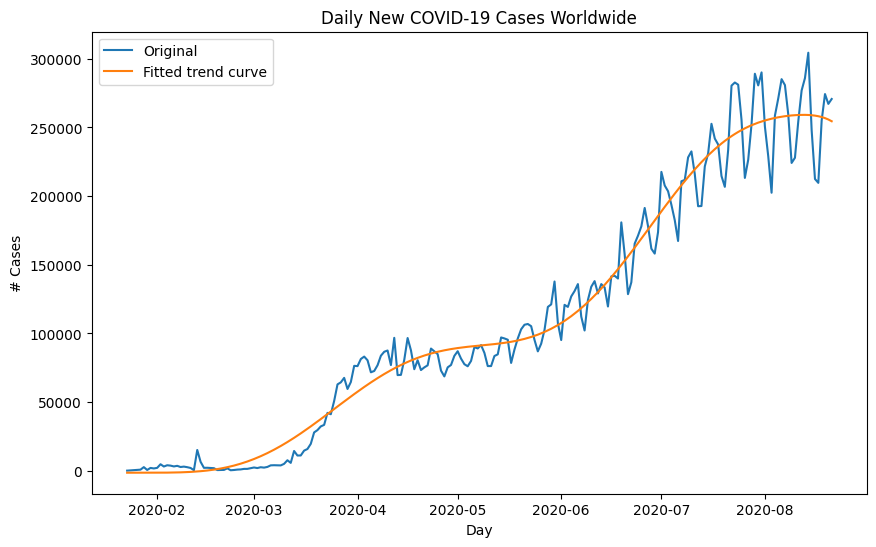

In [7]:
# Let's plot and see your regression line

fig, ax = plt.subplots(figsize=(10, 6))
ser = load_data()
preds = fit_trend(ser, 10)
ax.plot(ser.index, ser.values, label="Original")
ax.plot(ser.index, preds, label="Fitted trend curve")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax, ser, preds

### Calculate Weighted Moving Average (WMA)

The regression method seems to give a fairly accurate description of the trend hidden in the time series. In this problem and the next, we will explore an alternative method for discovering trends that is based on moving averages.

In [8]:


def calc_wma(ser, wd_size, weights=1):
    """
    Takes in a series and calculates the WMA with a window size of wd_size
    """
    # Create an array filled with NaN, which we'll replace with WMA values
    wma = np.empty_like(ser, dtype=float)
    wma[:] = np.NaN

    # If weights are provided as an integer, convert it to a repeating array
    if isinstance(weights, int):
        weights = np.full(wd_size, weights, dtype=float)

    assert len(weights) == wd_size, "Q4: The size of the weights must be the same as the window size. "

    # Iterate through the series
    for j in range(len(ser)):
        if j >= wd_size:
            wma[j] = np.sum(ser[j-wd_size+1:j+1] * weights) / np.sum(weights)
        else:
            wma[j] = np.sum(ser[:j+1] * weights[-(j+1):]) / np.sum(weights[-(j+1):])
    
    return wma


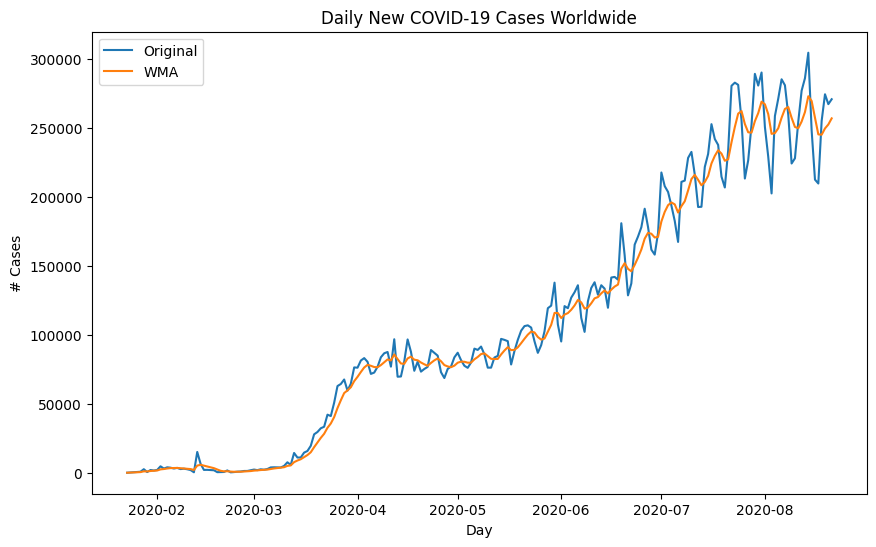

In [9]:
# Let's plot and see your WMA

fig, ax = plt.subplots(figsize=(10, 6))
wd_size = 7
weights = np.arange(1, wd_size + 1)
ser = load_data()
wma = calc_wma(ser, wd_size, weights=weights)

ax.plot(ser.index, ser.values, label="Original")
ax.plot(ser.index, wma, label="WMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax, wd_size, weights, ser, wma

### Calculate "Time" Exponential Moving Average (EMA) 

WMA usually works well if each data point is sampled at regular time intervals (which is the case for our time series). "Time" Exponential Moving Average (EMA), on the other hand, works well on both regular and irregular time series. Let's now explore how to apply EMA to our time series.

In [10]:


def calc_time_ema(ser, lmbd=0.0):
    """
    Takes in a series and calculates EMA with the lambda provided
    """
    #HINT: code the equation in the instructions 
    #check if lambda is equal to 0
        #for each instance in the series iterate through each slice 
            #append the numpy mean of the series instance +1 
    #else 
        #for each instance in the series iterate through each slice 
            #create numerator = 0 
            #create denominator = 0 
            #for j in range of index+1 
                #calculate the weight using the formula 
                #what would be the numerator? What is the denominator? Create them both using the formula #HINT use the weight you created 
        #append the numerator over the denominator to time_ema 
    #convert time_ema to a numpy array 
    
    
    time_ema = []
    
    # When lambda is 0, it becomes a Cumulative Moving Average
    if lmbd == 0:
        for i in range(len(ser)):
            time_ema.append(np.mean(ser[:i+1]))
    else:
        for i in range(len(ser)):
            numerator = 0
            denominator = 0
            for j in range(i+1):
                weight = np.exp(-lmbd * (i - j))
                numerator += weight * ser[j]
                denominator += weight
            time_ema.append(numerator / denominator)

    return np.array(time_ema)


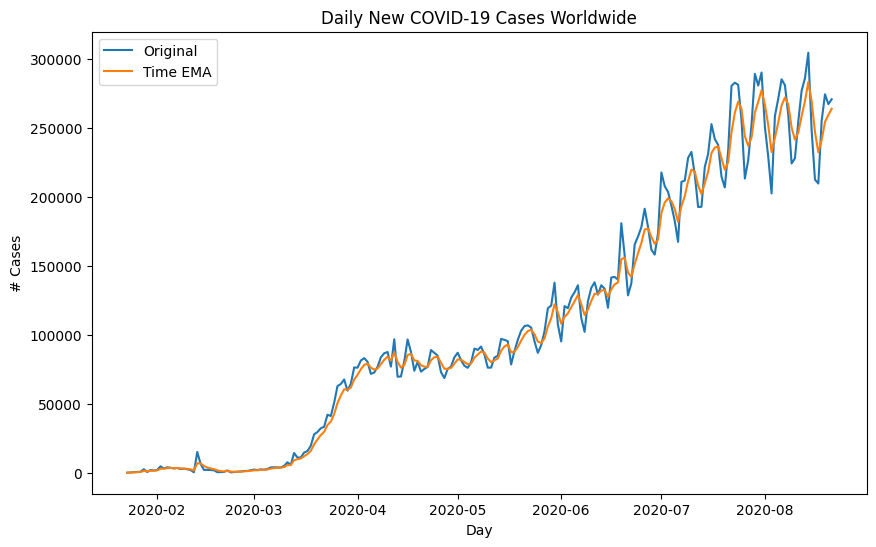

In [11]:
# Let's plot and see your time EMA

fig, ax = plt.subplots(figsize=(10, 6))
ser = load_data()
ema = calc_time_ema(ser, lmbd=0.5)

ax.plot(ser.index, ser.to_numpy(), label="Original")
ax.plot(ser.index, ema, label="Time EMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax, ser, ema

The SimpleExpSmoothing class from the statsmodels library is a handy tool for EMA. See an example below.

C:\Users\qfu88\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


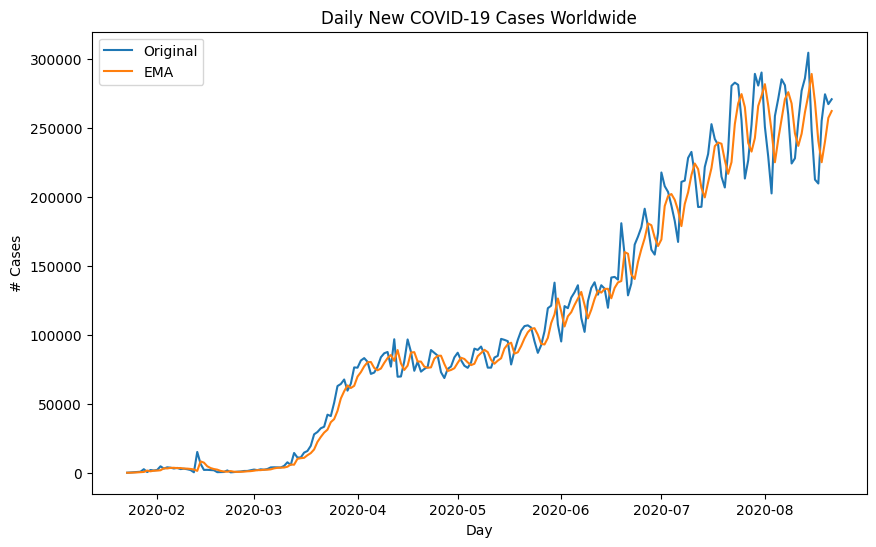

In [12]:
from statsmodels.tsa.api import SimpleExpSmoothing

fig, ax = plt.subplots(figsize=(10, 6))

ser = load_data()
ema = SimpleExpSmoothing(ser, initialization_method=None).fit(smoothing_level=0.5, optimized=False)

ax.plot(ser, label="Original")
ax.plot(ema.fittedvalues, label="EMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del ser, ema, fig, ax

## Time Series Similarities

### Load Data

In [13]:


def load_data_two():
    df = pd.read_csv('Data/time_series_covid19_confirmed_global.csv')
    

    # Drop 'Province/State', 'Lat', and 'Long' columns and group by 'Country/Region', summing over dates
    df = df.drop(columns=['Province/State', 'Lat', 'Long']).groupby('Country/Region').sum()

    # Transpose the dataframe so dates are rows
    df = df.T

    # Convert the index to a DatetimeIndex
    df.index = pd.to_datetime(df.index)

    # Filter data up to August 21, 2020
    df = df[(df.index >= '2020-01-23') & (df.index <= '2020-08-21')]


    # Get the top 5 countries with the most cumulative cases as of August 21, 2020
    top5_countries = df.loc['2020-08-21'].nlargest(5).index.tolist()

    # Filter the dataframe to only include the top 5 countries
    df = df[top5_countries]

    # Calculate daily new cases
    daily_new_cases = df.diff().fillna(df)

    return daily_new_cases



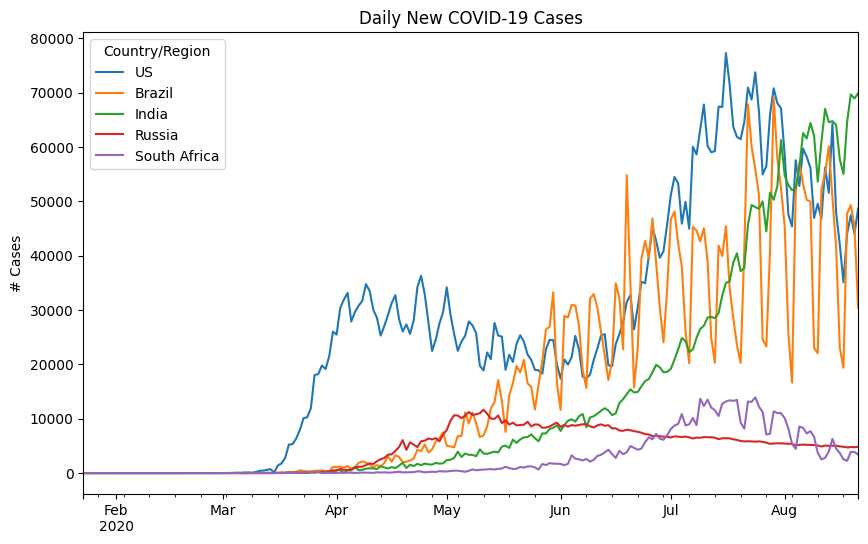

In [14]:
# Let's plot and see the time series
axes = load_data_two().plot(figsize=(10, 6), title="Daily New COVID-19 Cases", ylabel="# Cases")


### Extract Seasonal Components

To extract the seasonal components using seasonal_decompose for each country, we can loop through the columns of the input dataframe and apply the decomposition method. 

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

def sea_decomp(df, model="additive"):
    """
    Takes in a DataFrame and extracts the seasonal components
    """
    sea_df = None
    
    sea_df = pd.DataFrame(index=df.index)
    
    # Loop through each country in the dataframe
    for country in df.columns:
        result = seasonal_decompose(df[country], model=model) 
        sea_df[country] = result.seasonal   # Extract the seasonal component
    
   
    
    return sea_df

In [16]:
sea_df = sea_decomp(load_data_two(), model="additive")
sea_df.head()

,US,Brazil,India,Russia,South Africa
2020-01-23,2431.762350,3380.626554,441.179428,-54.886371,322.986535
2020-01-24,3446.796833,3457.641332,621.396176,23.689984,362.434811
2020-01-25,578.565306,586.665963,594.066127,55.034811,391.346141
2020-01-26,-2728.458503,-6031.950950,46.655454,137.908703,76.880131
2020-01-27,-3293.853741,-7144.674760,-1234.673118,1.842036,-507.496059


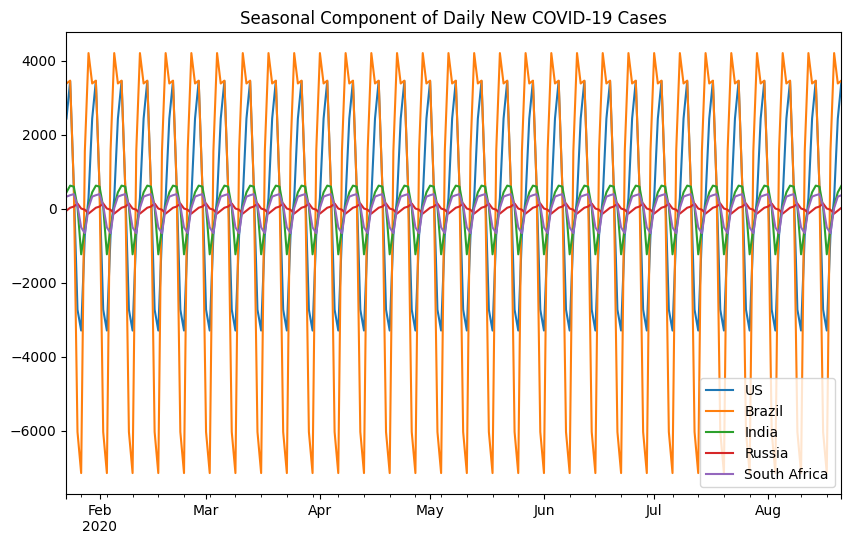

In [17]:
# Let's plot and see the seasonal components

df = load_data_two()
axes = sea_decomp(df).plot(figsize=(10, 6), title="Seasonal Component of Daily New COVID-19 Cases")



###  Calculate Euclidean Distance

Now, we may start to ask questions like, "which country in the top 5 countries are the most similar to Country A in terms of seasonal patterns?". In addition to the seasonal components that reflect seasonal patterns, we also need a measure of similarity between two time series in order to answer questions like this. One of such measures is the good old Euclidean Distance.

To compute pairwise Euclidean distances among columns of the dataframe, we can utilize a nested loop to iterate over each pair of columns (countries). For each pair, we will compute the Euclidean distance using the formula provided and store the result in the output dataframe.

In [18]:


def calc_euclidean_dist(df):
    """
    Takes in a DataFrame and computes all pairwise Euclidean Distance
    """
    #extract countries
    countries = df.columns
    #create a empty df which the column and rows are both coutries
    euclidean_dist_df = pd.DataFrame(index=countries, columns=countries, dtype=float)
    
    #nest loop to fill values(distance) into the empty df
    for country1 in countries:
        for country2 in countries:
            diff = df[country1] - df[country2]
            distance = np.sqrt(np.sum(diff**2))
            euclidean_dist_df.loc[country1, country2] = float(distance)#the value of the euclidean_dist_df
    
    return euclidean_dist_df


In [19]:
# Let's show the pairwise Euclidean Distance matrix

df = load_data_two()
calc_euclidean_dist(sea_decomp(df))

,US,Brazil,India,Russia,South Africa
US,0.000000,37616.739472,27032.902500,33986.317685,30084.557610
Brazil,37616.739472,0.000000,57583.437987,63663.896821,60839.376478
India,27032.902500,57583.437987,0.000000,9102.412727,4490.020448
Russia,33986.317685,63663.896821,9102.412727,0.000000,5658.222387
South Africa,30084.557610,60839.376478,4490.020448,5658.222387,0.000000


### Calculate Cosine Similarity

Another commonly used similarity measure is the Cosine Similarity. Recall that the Cosine Similarity between two vectors  𝑥
  and  𝑦
  is the cosine of the angle between  𝑥
  and  𝑦
 :

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def calc_cos_sim(df):
    """
    Takes in a DataFrame and computes all pairwise Cosine Similarity
    """
    # Compute the cosine similarity matrix
    cos_sim_matrix = cosine_similarity(df.T)
    #if you want to compute the pairwise cosine similarities between your time series (which are represented as columns in df)
    #you need to transpose the DataFrame using .T to make each time series a row.
    
    # Convert this matrix to a DataFrame with appropriate indices and column names
    cos_sim_df = pd.DataFrame(cos_sim_matrix, index=df.columns, columns=df.columns)
    
    return cos_sim_df


In [21]:
df = load_data_two()
calc_cos_sim(sea_decomp(df))

,US,Brazil,India,Russia,South Africa
US,1.000000,0.868859,0.783850,-0.325066,0.664260
Brazil,0.868859,1.000000,0.632741,-0.629987,0.403198
India,0.783850,0.632741,1.000000,0.092292,0.917529
Russia,-0.325066,-0.629987,0.092292,1.000000,0.174437
South Africa,0.664260,0.403198,0.917529,0.174437,1.000000


### Calculate Dynamic Time Warping (DTW) Cost

Last but not least, the cost of aligning two time series can also be used as a similarity measure. Two time series are more similar if it incurs less cost to align them. One of the commonly used alignment costs is the Dynamic Time Warping (DTW) cost,

In [22]:
import math

def calc_pairwise_dtw_cost(x, y, ret_matrix=False):
    """
    Takes in two series. If ret_matrix=True, returns the full DTW cost matrix; 
    otherwise, returns only the overall DTW cost
    """
    
    cost_matrix = np.zeros((len(y), len(x)))
    dtw_cost = None
    
    dist_fn = lambda a, b: (a - b) ** 2  # Optional helper function 
    
    #HINT: How to read the equation: 
    #HINT: i,j are rows, columns. You might want to create a double loop
    #HINT: You can use infinity from math.inf 
    #In each cordinate i,j (row,column)
        #If the coordinate is (0,0): define the cost matrix as d(x_(i),y_(j))
        #Otherwise;
            #the cost matrix is equal to the sum of d(x_(i),y_(j)) and the minimum of the following:
    #                          1)  If the row is less than or equal to zero;
    #                                      * compute the cost matrix using i and j-1
    #                              Else: too large to compute
    #                          2)  If the column is less than or equal to zero;
    #                                      * compute the cost matrix using i-1 and j
    #                              Else: too large to compute
    #                          3)  If the row and columns are less than or equal to zero;
    #                                      * too large to compute   
    
    
    cost_matrix[0, 0] = dist_fn(x[0], y[0])
    
    # Initialize the first row
    for j in range(1, len(x)):
        cost_matrix[0, j] = cost_matrix[0, j-1] + dist_fn(x[j], y[0])
    
    # Initialize the first column
    for i in range(1, len(y)):
        cost_matrix[i, 0] = cost_matrix[i-1, 0] + dist_fn(x[0], y[i])
        
    
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost = dist_fn(x[j], y[i])
            cost_matrix[i, j] = cost + min(cost_matrix[i-1, j], cost_matrix[i, j-1], cost_matrix[i-1, j-1])
    
    dtw_cost = cost_matrix[-1, -1]
    
    
    
    
    return cost_matrix if ret_matrix else dtw_cost 

Now let's compute all pairwise DTW costs for our five time series. Complete the function below that accepts a pd.DataFrame, whose columns are the time series for each country, and that returns all pairwise DTW costs among these time series

In [23]:
def calc_dtw_cost(df):
    """
    Takes in a DataFrame and computes all pairwise DTW costs
    """
    
    dtw_cost_df = None
    countries = df.columns
    num_countries = len(countries)
    
    dtw_cost_df = pd.DataFrame(index=countries, columns=countries, dtype=float)
    
    
    for i in range(num_countries):
        for j in range(num_countries):
            # Use the calc_pairwise_dtw_cost function to compute the DTW cost
            dtw_cost = calc_pairwise_dtw_cost(df[countries[i]], df[countries[j]])
            dtw_cost_df.at[countries[i], countries[j]] = float(dtw_cost)
   
    
    return dtw_cost_df

In [24]:
# Let's show the pairwise DTW costs matrix

df = load_data_two()
np.sqrt(calc_dtw_cost(sea_decomp(df)))

,US,Brazil,India,Russia,South Africa
US,0.000000,31878.166593,23565.959272,32327.427020,28016.527233
Brazil,31878.166593,0.000000,53400.789074,61868.013722,57143.198022
India,23565.959272,53400.789074,0.000000,7687.627537,4463.425362
Russia,32327.427020,61868.013722,7687.627537,0.000000,4259.096369
South Africa,28016.527233,57143.198022,4463.425362,4259.096369,0.000000
